In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9c7fc624-01a4-0dc5-de9d-139bf6c11ac0)


In [2]:
#getting the helper functions ready
!wget https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py

--2023-12-17 03:30:59--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py [following]
--2023-12-17 03:30:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-17 03:31:00 (90.5 MB/s) - ‘helper_

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Getting the dataset

In [4]:
import tensorflow_datasets as tfds

dataset_list = tfds.list_builders()
print("food101" in dataset_list)

True


In [5]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files= True,
                                             as_supervised = True,
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteM5S4XR/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteM5S4XR/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# getting the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# checking one sample of the train data
train_one_sample = train_data.take(1) # sample = image_tensor, label
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
#
for image, label in train_one_sample:
  print(f"""
    Image shape : {image.shape}
    Image Datatype : {image.dtype}
    Target Class (tensor form) : {label}
    Class name (str form) : {class_names[label.numpy()]}
  """)


    Image shape : (512, 512, 3)
    Image Datatype : <dtype: 'uint8'>
    Target Class (tensor form) : 16
    Class name (str form) : cheesecake
  


In [ ]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[131,  86,  55],
        [134,  89,  58],
        [137,  92,  61],
        ...,
        [131,  44,   0],
        [135,  49,   2],
        [138,  52,   5]],

       [[134,  89,  58],
        [135,  90,  59],
        [135,  90,  59],
        ...,
        [133,  46,   1],
        [134,  48,   1],
        [134,  48,   1]],

       [[136,  91,  60],
        [137,  92,  61],
        [139,  94,  63],
        ...,
        [137,  53,   7],
        [135,  51,   5],
        [131,  47,   1]],

       ...,

       [[130,  23,   3],
        [134,  31,  14],
        [132,  36,  24],
        ...,
        [243, 248, 242],
        [243, 248, 242],
        [243, 248, 242]],

       [[128,  22,   0],
        [129,  26,   7],
        [124,  28,  14],
        ...,
        [243, 248, 241],
        [242, 247, 240],
        [242, 247, 240]],

       [[132,  26,   2],
        [133,  31,   9],
        [126,  29,  13],
        ...,
        [242, 247, 24

In [12]:
import tensorflow as tf

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plotting as image from tf datasets

Text(0.5, 1.0, 'cheesecake')

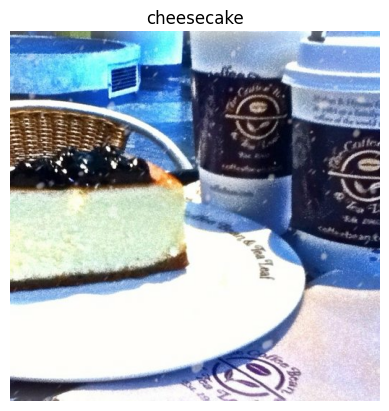

In [13]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis("off")
plt.title(class_names[label.numpy()])

## Create preprocessing functions for our data

In [14]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'unit8' -> 'float32' and reshapes
  image to {img_shape, img_shape, color_channels}
  """
  image = tf.image.resize(image, [img_shape,img_shape])
  # image = image/255. #not required with efficientNetBX models
  return tf.cast(image , tf.float32), label

In [15]:
preprocessed_image = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_image[:2]}...,\nShape: {preprocessed_image.shape}, \nDatatype: {preprocessed_image.dtype}\n")

Image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]...,
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]...,
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>



## Batching and preparing the data

In [16]:
# map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

#shuffle train_data and turn it into batches and prefetch it(load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# map preprocessing function to the test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
train_data ,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating model callbacks

In [18]:
from helper_functions import create_tensorboard_callback

#model checkpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="vall_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)


## Setup mixed precision training

In [19]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [20]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Creating a FeatureExtractor model

In [21]:
import tensorflow as tf

#creating the base model
input_shape =(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# creating a functional model
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
# x = tf.keras.layers.experimental.preprocessing(1./255)(x) # not for efficient net model
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype policies

In [23]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [24]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

## Fitting the feature extraction model

In [25]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs = 3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs","efficientb0_101_classes_all_data_features_extractor"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_features_extractor/20231217-034615
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7160 - accuracy: 0.5816

2368/2368 [==============================] - 216s 84ms/step - loss: 1.7160 - accuracy: 0.5816 - val_loss: 1.1268 - val_accuracy: 0.6981
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1996 - accuracy: 0.6894

2368/2368 [==============================] - 178s 74ms/step - loss: 1.1996 - accuracy: 0.6894 - val_loss: 1.0196 - val_accuracy: 0.7206
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0539 - accuracy: 0.7235

2368/2368 [==============================] - 197s 82ms/step - loss: 1.0539 - accuracy: 0.7235 - val_loss: 1.0001 - val_accuracy: 0.7275


In [26]:
# evaluate model on the whole test dataset
results_feature_extract_model = model.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 0.9981 - accuracy: 0.7273


## Saving the model

In [27]:
save_dir = "efficientNetB0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [28]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [31]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 51s 62ms/step - loss: 0.9981 - accuracy: 0.7273


[0.9981343746185303, 0.7272871136665344]

In [37]:
import numpy as np
print(np.isclose(results_loaded_saved_model,results_feature_extract_model))

[ True  True]


## Fine Tuning our model


In [38]:
model_2 = tf.keras.models.load_model(save_dir)

In [39]:
for layer in model_2.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [40]:
for layer in model_2.layers:
  layer.trainable = True

In [42]:
for layer in model_2.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
rescaling_1 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float

In [43]:
# creating callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience = 3)
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only = True,
                                                      monitor="val_loss")

In [45]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.2,
                                                patience=2,
                                                verbose=1,
                                                min_lr=1e-7)

In [46]:
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=["accuracy"])

In [47]:
history_101_food_classes_all_data_fine_tune = model_2.fit(train_data,
                                                          epochs=100,
                                                          steps_per_epoch = len(train_data),
                                                          validation_data = test_data,
                                                          validation_steps = int(0.15 * len(test_data)),
                                                          callbacks=[model_checkpoint,
                                                                   early_stopping,
                                                                   reduce_lr])

Epoch 1/100
2368/2368 [==============================] - 477s 179ms/step - loss: 0.8715 - accuracy: 0.7650 - val_loss: 0.7523 - val_accuracy: 0.7873 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 395s 166ms/step - loss: 0.5394 - accuracy: 0.8501 - val_loss: 0.7579 - val_accuracy: 0.7956 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.9125
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 367s 154ms/step - loss: 0.3049 - accuracy: 0.9125 - val_loss: 0.8336 - val_accuracy: 0.7897 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 365s 153ms/step - loss: 0.0765 - accuracy: 0.9818 - val_loss: 0.8902 - val_accuracy: 0.8072 - lr: 2.0000e-05


In [48]:
results_main_model = model_2.evaluate(test_data)
results_main_model

790/790 [==============================] - 52s 65ms/step - loss: 0.9046 - accuracy: 0.8037


[0.9046443104743958, 0.8037227988243103]

In [49]:
model_2.save("FoodVisionFineTunedModel")

In [50]:
model_2.save("FoodVisionFineTunedModel.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [110]:
!zip -r /content/FoodVisionFineTunedModel.zip /content/FoodVisionFineTunedModel

  adding: content/FoodVisionFineTunedModel/ (stored 0%)
  adding: content/FoodVisionFineTunedModel/fingerprint.pb (stored 0%)
  adding: content/FoodVisionFineTunedModel/assets/ (stored 0%)
  adding: content/FoodVisionFineTunedModel/saved_model.pb (deflated 91%)
  adding: content/FoodVisionFineTunedModel/keras_metadata.pb (deflated 96%)
  adding: content/FoodVisionFineTunedModel/variables/ (stored 0%)
  adding: content/FoodVisionFineTunedModel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/FoodVisionFineTunedModel/variables/variables.index (deflated 76%)


## Evaluating and Loss curves and confusion matrix



In [127]:
pred_probs = model_2.predict(test_data, verbose=1)

790/790 [==============================] - 50s 63ms/step


In [128]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10], len(pred_classes), pred_classes.shape

(array([44, 83, 79, 21, 51, 12, 17,  5, 13, 42]), 25250, (25250,))

In [129]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[57, 37, 99, 40, 60, 1, 69, 52, 62, 77]

In [130]:
pred_classes==y_labels

array([False, False, False, ..., False, False, False])

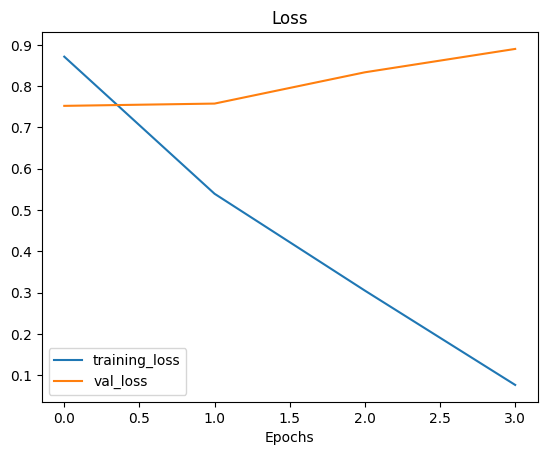

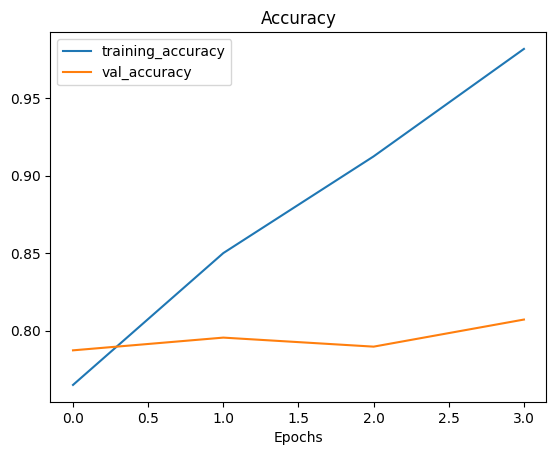

In [131]:
plot_loss_curves(history_101_food_classes_all_data_fine_tune)

# Prediction with custom images

In [152]:
def prep_image(filename , img_shape=224):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img,channels=3)
  img = tf.image.resize(img, size=[img_shape,img_shape])
  img = img/255.
  img = tf.expand_dims(img, axis=0)
  return img

def pred_and_plot(model, filename, class_names):
    img = prep_image(filename)

    pred = model.predict(img)
    predicted_class_index = tf.argmax(pred, axis=1)[0].numpy()
    pred_class = class_names[predicted_class_index]

    img = tf.squeeze(img,axis = 0)
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    print(pred.argmax())

1/1 [==============================] - 0s 61ms/step
9


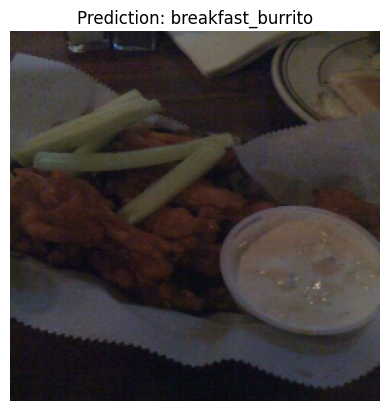

In [154]:
pred_and_plot(model_2, "/content/26597.jpg", class_names)

1/1 [==============================] - 0s 49ms/step
9


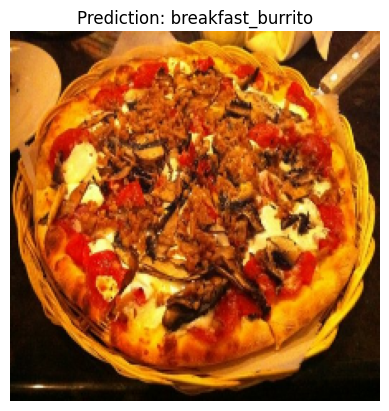

In [150]:
pred_and_plot(model_2, "/content/340814.jpg", class_names)
